<a href="https://colab.research.google.com/github/AlonResearch/SNN-for-MI-EEG/blob/main/MI3_SNNforMIeeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import torch
import torch.utils.data as da
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.io as scio
!pip install spikingjelly -q
from spikingjelly.activation_based import ann2snn
#!apt install -y graphviz graphviz-dev -q
#!pip install nnviz -q
#from nnviz import drawing
#import matplotlib.pyplot as plt


In [4]:

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
!nvidia-smi

Using cuda device
Wed May  7 12:22:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------

In [5]:
# @title Data loader and other functions
#Defining functions

def data_loader(data, label, batch=64, shuffle=True, drop=False):
    """
    Preprocess the data to fit model.
    Feed data into data_loader.
    input:
        data (float): samples*length*ch (samples*ch*length).
        label (int): samples, ie.: [0, 1, 1, 0, ..., 2].
        batch (int): batch size
        shuffle (bool): shuffle data before input into decoder
        drop (bool): drop the last samples if True
    output:
        data loader
    """
    label = torch.LongTensor(label.flatten()).to(device)
    if data.shape[1] >= data.shape[2]:
        data = torch.tensor(data.swapaxes(1, 2))
    data = torch.unsqueeze(data, dim=1).type('torch.FloatTensor').to(device)
    data = da.TensorDataset(data, label)
    loader = da.DataLoader(dataset=data, batch_size=batch, shuffle=shuffle, drop_last=drop)
    return loader


def val_snn(Dec, test_loader, T=None):
    Dec.eval().to(device)
    correct = 0
    total = 0
    if T is not None:
        corrects = np.zeros(T)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            if T is None:
                outputs = Dec(inputs)
                correct += (outputs.argmax(dim=1) == targets.to(device)).float().sum().item()
            else:
                for m in Dec.modules():
                    if hasattr(m, 'reset'):
                        m.reset()
                for t in range(T):
                    if t == 0:
                        outputs = Dec(inputs)
                    else:
                        outputs += Dec(inputs)
                    corrects[t] += (outputs.argmax(dim=1) == targets.to(device)).float().sum().item()
            total += targets.shape[0]
    return correct / total if T is None else corrects / total


def anntosnn(cnn_model, train_x, train_y, test_x, test_y, batch=64, T=None):
    # Define data loader
    train_loader = data_loader(train_x, train_y, batch=batch)
    test_loader = data_loader(test_x, test_y, batch=batch)

    print('---------------------------------------------')
    print('Converting using MaxNorm')
    model_converter = ann2snn.Converter(mode='max', dataloader=train_loader)
    snn_model = model_converter(cnn_model)
    mode_max_accs = val_snn(snn_model, test_loader, T=T)

    return mode_max_accs


torch.backends.cudnn.benchmark = True

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


def train_ann(cnn_model, train_x, train_y, test_x, test_y, ep=500, batch=64):
    """
    input:
        train_x, test_x (float): samples*length*ch (samples*ch*length).
        train_y, test_y (int): samples, ie.: [0, 1, 1, 0, ..., 2].
        ep (int): total train and test epoch
        batch (int): batch size
    output:
        train acc, test acc, weight_file
    """
    # Define training configuration
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.01)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ep)

    # Define data loader
    train_loader = data_loader(train_x, train_y, batch=batch)
    test_loader = data_loader(test_x, test_y, batch=batch)

    train_acc = []
    test_acc = []
    for epoch in range(ep):
        # Train ANN
        cnn_model.train()
        train_loss = 0
        correct = 0
        total = 0
        loss = 0
        print('\n')
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = cnn_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            print(batch_idx, len(train_loader), 'Epoch: %d | ANN: trainLoss: %.4f | trainAcc: %.4f%% (%d/%d)'
                  % (epoch, train_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        lr_scheduler.step()
        train_acc.append(round(correct / total, 4))

        # Test ANN
        cnn_model.eval()
        val_loss = 0
        correct = 0
        total = 0
        loss = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                outputs = cnn_model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                print(batch_idx, len(test_loader), 'Epoch: %d | ANN: testLoss: %.4f | testAcc: %.4f%% (%d/%d)'
                      % (epoch, val_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        test_acc.append(round(correct / total, 4))

    train_acc = np.asarray(train_acc[-1])
    test_acc = np.asarray(test_acc[-1])
    return train_acc, test_acc,cnn_model

In [6]:
# @title Model definitions
# Model 2a

class LENet(nn.Module):
    """
        LENet Model
    input:
         data shape as: batch_size*1*channel*length (64*1*22*1000) BCI IV-2a
         batch_size：64
         channel：22
         length：1000
    output:
        classes_num
    """

    def __init__(self, classes_num=3, channel_count=22, drop_out = 0.5):
        super(LENet, self).__init__()
        self.drop_out = drop_out

        self.block_TCB_1 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,64) #
            nn.ZeroPad2d((32, 31, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 64),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_2 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,32) #
            nn.ZeroPad2d((16, 15, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 32),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_3 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,16) #
            nn.ZeroPad2d((8, 7, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 16),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )

        self.TCB_fusion = nn.Sequential(
            # Temporal Convolution block fusion kernel_size (1,1) #
            nn.Conv2d(
                in_channels=24,
                out_channels=24,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(24)
        )

        self.SCB = nn.Sequential(
            # Spatial Convolution block kernel_size (channel,1) #
            nn.Conv2d(
                in_channels=24,
                out_channels=16,
                kernel_size=(channel_count, 1),
                groups=8,
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.drop_out)
        )

        self.FFCB = nn.Sequential(
            # Feature Fusion Convolution block kernel_size (1,16) and (1,1) #
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 16),
                groups=16,
                bias=False
            ),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 1),
                bias=False
            ),  #
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.drop_out)
        )

        self.CCB = nn.Sequential(
            # Classification Convolution block kernel_size (1,1) #
            nn.Conv2d(
                in_channels=16,
                out_channels=classes_num,
                kernel_size=(1, 1),
                bias=False
            ),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

    def forward(self, x):
        x1 = self.block_TCB_1(x)
        x2 = self.block_TCB_2(x)
        x3 = self.block_TCB_3(x)
        x4 = torch.cat([x1, x2, x3], dim=1)
        x = self.TCB_fusion(x4)
        x = self.SCB(x)
        x = self.FFCB(x)
        x = self.CCB(x)
        return x

class LENet_FCL(nn.Module):
    def __init__(self, classes_num=3, channel_count=60, drop_out=0.5):
        super(LENet_FCL, self).__init__()
        self.drop_out = drop_out

        # Keep all the convolutional layers the same
        self.block_TCB_1 = nn.Sequential(
            nn.ZeroPad2d((32, 31, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 64),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_2 = nn.Sequential(
            nn.ZeroPad2d((16, 15, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 32),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_3 = nn.Sequential(
            nn.ZeroPad2d((8, 7, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 16),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )

        self.TCB_fusion = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=24,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(24)
        )

        self.SCB = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=16,
                kernel_size=(channel_count, 1),
                groups=8,
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.drop_out)
        )

        self.FFCB = nn.Sequential(
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 16),
                groups=16,
                bias=False
            ),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 1),
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.drop_out)
        )

        # We'll determine the size of the FC layer in the forward pass
        self.flatten = nn.Flatten()
        self.fc = None
        self.classes_num = classes_num

    def forward(self, x):
        x1 = self.block_TCB_1(x)
        x2 = self.block_TCB_2(x)
        x3 = self.block_TCB_3(x)
        x4 = torch.cat([x1, x2, x3], dim=1)
        x = self.TCB_fusion(x4)
        x = self.SCB(x)
        x = self.FFCB(x)

        # Flatten the output
        x = self.flatten(x)

        # Create the FC layer on first forward pass if it doesn't exist
        if self.fc is None:
            in_features = x.shape[1]
            self.fc = nn.Linear(in_features, self.classes_num).to(x.device)
            # Initialize weights for the new layer
            nn.init.kaiming_normal_(self.fc.weight, mode="fan_out", nonlinearity="relu")
            if self.fc.bias is not None:
                nn.init.constant_(self.fc.bias, 0)

        # Apply the FC layer
        x = self.fc(x)
        return x

In [7]:
# @title Loading the data
"""
Loading the data
"""

# Getting real samples
#Locally load the dataset
#file = scio.loadmat('Datasets\BCICIV_2a_gdf\Derivatives\A01T.mat')

# Google Colab load the dataset
file = scio.loadmat('/content/sub-011_eeg90hz_7-35.mat')


all_data = file['all_data']
all_label = file['all_label']
REDUCE_REST = 1

# Print data information
channel_count = all_data.shape[1]
num_classes = len(np.unique(all_label.flatten()))
data_length = all_data.shape[2] # Assuming data is samples*ch*length
print(f"Channel count: {channel_count}")
print(f"Data shape: {all_data.shape}")
print(f"Label shape: {all_label.shape}")
print(f"Class distribution: Rest: {np.sum(all_label == 0)}, Elbow: {np.sum(all_label == 1)}, Hand: {np.sum(all_label == 2)}")

# Address class imbalance for 'Rest' class (label 0)
label_0_indices = np.where(all_label.flatten() == 0)[0]
label_other_indices = np.where(all_label.flatten() != 0)[0]

# Randomly select "REDUCE_REST"% of label 0 indices
num_label_0_to_keep = int(len(label_0_indices) * REDUCE_REST)
#np.random.seed(42) # for reproducibility
selected_label_0_indices = np.random.choice(label_0_indices, size=num_label_0_to_keep, replace=False)

# Combine selected label 0 indices with all other labels
balanced_indices = np.concatenate((selected_label_0_indices, label_other_indices))
np.random.shuffle(balanced_indices) # Shuffle the combined dataset

all_data_balanced = all_data[balanced_indices]
all_label_balanced = all_label[balanced_indices]

print(f"Balanced class distribution: Rest: {np.sum(all_label_balanced == 0)}, Elbow: {np.sum(all_label_balanced == 1)}, Hand: {np.sum(all_label_balanced == 2)}")
print(f"Balanced data shape: {all_data_balanced.shape}")
print(f"Balanced label shape: {all_label_balanced.shape}")

datasetX = torch.tensor(all_data_balanced, dtype=torch.float32)
datasetY = torch.tensor(all_label_balanced, dtype=torch.int64)

Channel count: 62
Data shape: (965, 62, 360)
Label shape: (965, 1)
Class distribution: Rest: 365, Elbow: 300, Hand: 300
Balanced class distribution: Rest: 365, Elbow: 300, Hand: 300
Balanced data shape: (965, 62, 360)
Balanced label shape: (965, 1)


In [8]:
# @title LENet to SNN Conversion Framework execution

# Hyperparameters
EPOCHS = 100
BATCH_SIZE = 64
TIME_STEPS = 100  # T for SNN
TEST_SIZE = 0.2
DROP_OUT = 0.25


# Split the data
print(f"{100 - (TEST_SIZE * 100)}% of the dataset is used for training and {TEST_SIZE * 100}% is used for testing.")
train_data, test_data, train_label, test_label = train_test_split(datasetX, datasetY, test_size=TEST_SIZE, shuffle=True,
                                                                  random_state=0)

# Initialize model
cnn_model_lenet = LENet(classes_num=3, channel_count=channel_count, drop_out = DROP_OUT).to(device)
cnn_model_lenet.apply(initialize_weights)

# Train CNN model
train_acc, test_acc,  cnn_model_lenet = train_ann(cnn_model_lenet, train_data, train_label, test_data, test_label,
                                              ep=EPOCHS, batch=BATCH_SIZE)
max_norm_acc = anntosnn( cnn_model_lenet, train_data, train_label, test_data, test_label,
                        batch=BATCH_SIZE, T=TIME_STEPS)
snn_model_lenet = ann2snn.Converter(mode='max', dataloader=data_loader(train_data, train_label, batch=BATCH_SIZE))( cnn_model_lenet)

print('\n')
print('ANN accuracy: Test: %.4f%%' % (test_acc * 100))
print('SNN accuracy: max_norm: %.4f%%' % (max_norm_acc[-1] * 100))

80.0% of the dataset is used for training and 20.0% is used for testing.


0 13 Epoch: 0 | ANN: trainLoss: 1.9497 | trainAcc: 43.7500% (28/64)
1 13 Epoch: 0 | ANN: trainLoss: 1.8127 | trainAcc: 38.2812% (49/128)
2 13 Epoch: 0 | ANN: trainLoss: 1.6671 | trainAcc: 38.5417% (74/192)
3 13 Epoch: 0 | ANN: trainLoss: 1.5789 | trainAcc: 38.2812% (98/256)
4 13 Epoch: 0 | ANN: trainLoss: 1.4707 | trainAcc: 40.9375% (131/320)
5 13 Epoch: 0 | ANN: trainLoss: 1.4148 | trainAcc: 39.8438% (153/384)
6 13 Epoch: 0 | ANN: trainLoss: 1.3749 | trainAcc: 40.1786% (180/448)
7 13 Epoch: 0 | ANN: trainLoss: 1.3219 | trainAcc: 42.3828% (217/512)
8 13 Epoch: 0 | ANN: trainLoss: 1.2933 | trainAcc: 43.7500% (252/576)
9 13 Epoch: 0 | ANN: trainLoss: 1.2668 | trainAcc: 44.3750% (284/640)
10 13 Epoch: 0 | ANN: trainLoss: 1.2439 | trainAcc: 45.0284% (317/704)
11 13 Epoch: 0 | ANN: trainLoss: 1.2241 | trainAcc: 45.5729% (350/768)
12 13 Epoch: 0 | ANN: trainLoss: 1.2243 | trainAcc: 45.4663% (351/772)
0 4 Epoch: 0 | AN

100%|██████████| 13/13 [00:00<00:00, 358.82it/s]



ANN accuracy: Test: 72.5400%
SNN accuracy: max_norm: 73.0570%


In [ ]:
# @title NN Visualization

# This block should be placed after the training and SNN conversion
# of the model you wish to visualize. For example, after the
# "LENet to SNN Conversion Framework execution" cell or
# after the "LENet_FCL to SNN Conversion Framework execution" cell.
# The `cnn_model_lenet` and `Snn_model_lenet` variables from that preceding cell
# will be used for visualization.

# Install nnviz if you haven't already (uncomment the line below if needed)
# !pip install nnviz

# Import necessary nnviz modules
from nnviz import drawing, inspection
import torch # Ensure torch is imported

print("Starting Neural Network Visualization...")

# --- CNN Model Visualization ---
if 'cnn_model_lenet' in locals() and isinstance(cnn_model_lenet, torch.nn.Module):
    model_to_visualize_cnn = cnn_model_lenet
    cnn_model_lenet_name = type(model_to_visualize_cnn).__name__
    print(f"\nVisualizing LENet CNN model: {cnn_model_lenet_name}")

    try:
        # Move model to CPU for inspection (safer for fx tracing)
        cnn_model_lenet_cpu = model_to_visualize_cnn.to('cpu')

        # Create an inspector
        # TorchFxInspector uses torch.fx to trace the model graph
        cnn_inspector = inspection.TorchFxInspector()

        # Inspect the CNN model
        # For models like LENet_FCL, training (as done in your script) ensures that
        # dynamically created layers (e.g., self.fc) are initialized before inspection.
        print(f"Inspecting {cnn_model_lenet_name} on CPU...")
        cnn_graph = cnn_inspector.inspect(cnn_model_lenet_cpu)

        # Create a drawer for saving the visualization (e.g., to a PDF file)
        # You can change the output format by changing the extension (e.g., .png, .svg)
        cnn_viz_filename = f"{cnn_model_lenet_name}_LENet_cnn_architecture.png"
        cnn_drawer = drawing.GraphvizDrawer(cnn_viz_filename)

        # Draw the graph and save it to the file
        cnn_drawer.draw(cnn_graph)
        print(f"LENet CNN model visualization saved to: {cnn_viz_filename}")
        print(
            f"Note: If the output file is empty or shows an error, ensure Graphviz "
            f"(specifically the 'dot' command) is installed and accessible in your system's PATH."
        )

    except Exception as e:
        print(
            f"An error occurred during CNN model ({cnn_model_lenet_name}) visualization: {e}"
        )
        print("Troubleshooting tips:")
        print("- Ensure 'nnviz' is installed.")
        print(
            "- Ensure 'graphviz' (dot executable) is installed and in your system's PATH."
        )
        print(
            "- The model structure might contain operations not traceable by torch.fx. "
            "Check nnviz documentation for advanced usage or alternative inspectors if needed."
        )
else:
    print(
        "\nCNN model ('cnn_model_lenet') not found in the current scope, or it's not a torch.nn.Module. "
        "Skipping CNN visualization."
    )
print("\nNeural Network Visualization process complete.")

In [10]:
# @title LENet_FCL to SNN Conversion Framework execution

# Hyperparameters
#EPOCHS = 300
#BATCH_SIZE = 128
#TIME_STEPS = 100  # T for SNN
#TEST_SIZE = 0.2
#DROP_OUT = 0.5


# Split the data
print(f"{100 - (TEST_SIZE * 100)}% of the dataset is used for training and {TEST_SIZE * 100}% is used for testing.")
train_data, test_data, train_label, test_label = train_test_split(datasetX, datasetY, test_size=TEST_SIZE, shuffle=True,
                                                                  random_state=0)

# Initialize model
cnn_model_lenet_fcl = LENet_FCL(classes_num=3, channel_count=channel_count, drop_out = DROP_OUT).to(device)
cnn_model_lenet_fcl.apply(initialize_weights)

# Train CNN model
train_acc, test_acc,  cnn_model_lenet_fcl = train_ann(cnn_model_lenet_fcl, train_data, train_label, test_data, test_label,
                                              ep=EPOCHS, batch=BATCH_SIZE)
max_norm_acc = anntosnn( cnn_model_lenet_fcl, train_data, train_label, test_data, test_label,
                        batch=BATCH_SIZE, T=TIME_STEPS)
snn_model_lenet_fcl = ann2snn.Converter(mode='max', dataloader=data_loader(train_data, train_label, batch=BATCH_SIZE))(cnn_model_lenet_fcl)

print('\n')
print('ANN accuracy: Test: %.4f%%' % (test_acc * 100))
print('SNN accuracy: max_norm: %.4f%%' % (max_norm_acc[-1] * 100))

80.0% of the dataset is used for training and 20.0% is used for testing.


0 13 Epoch: 0 | ANN: trainLoss: 3.1822 | trainAcc: 31.2500% (20/64)
1 13 Epoch: 0 | ANN: trainLoss: 2.8351 | trainAcc: 35.9375% (46/128)
2 13 Epoch: 0 | ANN: trainLoss: 2.8573 | trainAcc: 35.4167% (68/192)
3 13 Epoch: 0 | ANN: trainLoss: 2.5634 | trainAcc: 38.6719% (99/256)
4 13 Epoch: 0 | ANN: trainLoss: 2.6083 | trainAcc: 35.6250% (114/320)
5 13 Epoch: 0 | ANN: trainLoss: 2.5967 | trainAcc: 35.6771% (137/384)
6 13 Epoch: 0 | ANN: trainLoss: 2.5266 | trainAcc: 36.6071% (164/448)
7 13 Epoch: 0 | ANN: trainLoss: 2.4522 | trainAcc: 37.3047% (191/512)
8 13 Epoch: 0 | ANN: trainLoss: 2.4524 | trainAcc: 37.3264% (215/576)
9 13 Epoch: 0 | ANN: trainLoss: 2.4030 | trainAcc: 37.8125% (242/640)
10 13 Epoch: 0 | ANN: trainLoss: 2.4027 | trainAcc: 37.7841% (266/704)
11 13 Epoch: 0 | ANN: trainLoss: 2.3559 | trainAcc: 38.1510% (293/768)
12 13 Epoch: 0 | ANN: trainLoss: 2.3596 | trainAcc: 38.0829% (294/772)
0 4 Epoch: 0 | AN

100%|██████████| 13/13 [00:00<00:00, 450.99it/s]



ANN accuracy: Test: 66.8400%
SNN accuracy: max_norm: 67.3575%


In [11]:
# @title Evaluate models
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib # For colormaps access

# Ensure all necessary variables from previous cells are available:
# cnn_model_lenet, snn_model_lenet, cnn_model_lenet_fcl, snn_model_lenet_fcl
# test_data, test_label (from the last train_test_split)
# BATCH_SIZE, TIME_STEPS, device
# data_loader function

# 0. Prepare data loader for evaluation (using test_data from the last split)
eval_test_loader = data_loader(test_data, test_label, batch=BATCH_SIZE, shuffle=False, drop=False)

true_labels_list = []
for _, targets_batch in eval_test_loader:
    true_labels_list.extend(targets_batch.cpu().numpy())
true_labels_np = np.array(true_labels_list)

# --- 1. Get predictions for all models ---
print("Generating predictions for all models...")
all_model_predictions = {}
model_objects = {
    "LENet CNN": cnn_model_lenet,
    "LENet SNN": snn_model_lenet,
    "LENet_FCL CNN": cnn_model_lenet_fcl,
    "LENet_FCL SNN": snn_model_lenet_fcl
}

for model_name, model_obj in model_objects.items():
    print(f"Evaluating {model_name}...")
    model_obj.eval().to(device)
    current_preds = []
    is_snn = "SNN" in model_name

    with torch.no_grad():
        for inputs, _ in eval_test_loader:
            inputs = inputs.to(device)
            if is_snn:
                for m_module in model_obj.modules():
                    if hasattr(m_module, 'reset'):
                        m_module.reset()
                accumulated_outputs = None
                for t in range(TIME_STEPS):
                    outputs_t = model_obj(inputs)
                    if accumulated_outputs is None:
                        accumulated_outputs = outputs_t.clone()
                    else:
                        accumulated_outputs += outputs_t
                _, predicted = accumulated_outputs.max(1)
            else: # ANN
                outputs = model_obj(inputs)
                _, predicted = outputs.max(1)
            current_preds.extend(predicted.cpu().numpy())
    all_model_predictions[model_name] = current_preds
print("All predictions generated.")

# --- 2. Calculate Accuracies for all models ---
accuracy_results = {}
class_names = ['Rest', 'Elbow', 'Hand'] # Corresponds to labels 0, 1, 2

for model_name, predictions in all_model_predictions.items():
    overall_acc = accuracy_score(true_labels_np, predictions)
    accuracy_results[model_name] = {"Overall": overall_acc}
    for class_idx, class_name_key in enumerate(class_names):
        class_indices = np.where(true_labels_np == class_idx)[0]
        if len(class_indices) > 0:
            class_true = true_labels_np[class_indices]
            class_pred = np.array(predictions)[class_indices]
            class_acc = accuracy_score(class_true, class_pred)
            accuracy_results[model_name][class_name_key] = class_acc
        else:
            accuracy_results[model_name][class_name_key] = np.nan
for model_name in all_model_predictions:
  print(model_name, end="|")

Generating predictions for all models...
Evaluating LENet CNN...
Evaluating LENet SNN...
Evaluating LENet_FCL CNN...
Evaluating LENet_FCL SNN...
All predictions generated.
LENet CNN|LENet SNN|LENet_FCL CNN|LENet_FCL SNN|

--- Experiment Configuration & Data Specifications ---
+-----------------------------------+-----------------------------------------+
| Parameter                          | Value                                    |
+===================================+=========================================+
| Dataset File                       | sub-011_eeg.mat                          |
| EEG Channels                       | 62                                       |
| Data Shape (Full Dataset)          | Samples: 965, Channels: 62, Length: 360  |
| Class Distribution (Full Dataset)  | Rest: 365, Elbow: 300, Hand: 300         |
| Bandpass Filter (Reported)         | 2-45Hz                                   |
| Sampling Ratio (Reported)          | 90Hz                                     |
| TRAINING EPOCHS                    | 100                                      |
| Dropout                            | 0.25                                     |
| Test Split                         | 0.2     

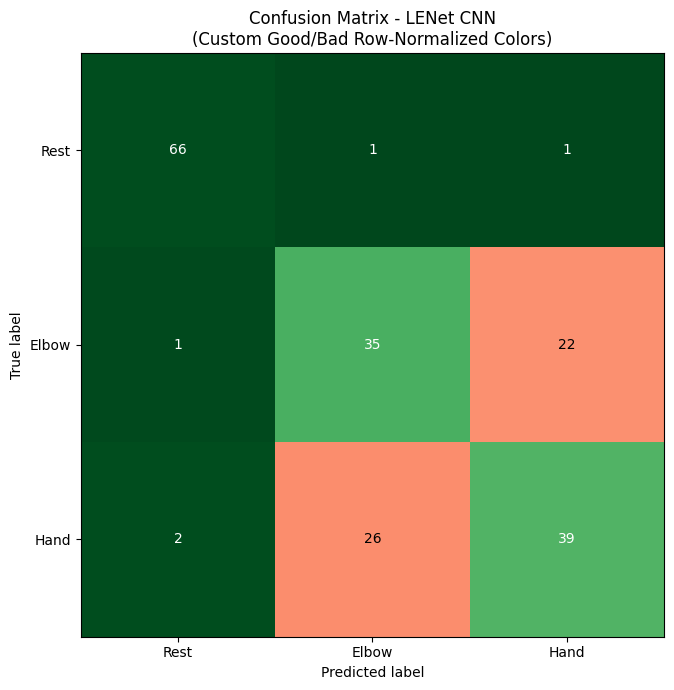


Figure 1: Confusion Matrix for LENet CNN.
This matrix visualizes classification performance with custom colors based on row-normalized values
Overall Accuracy: 72.54%.
Accuracy for Rest: 97.06%.
Accuracy for Elbow: 60.34%.
Accuracy for Hand: 58.21%.
----------------------------------------------------------------------


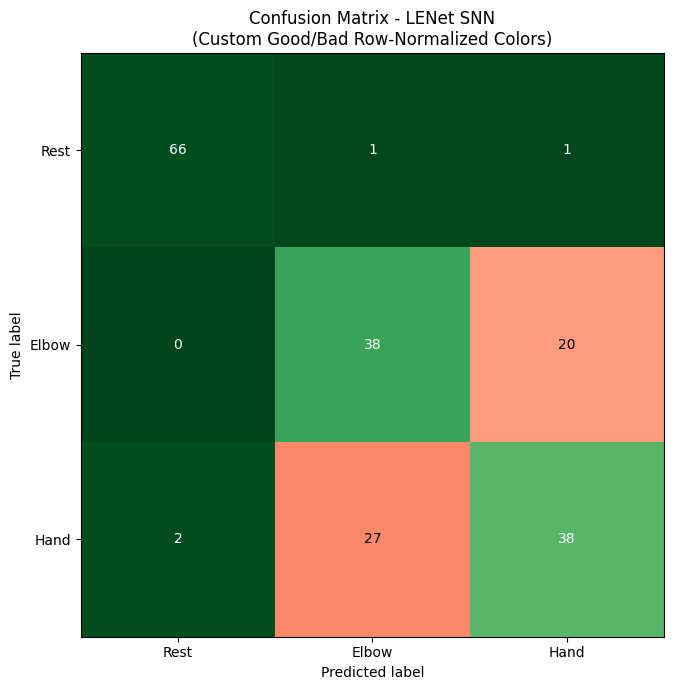


Figure 2: Confusion Matrix for LENet SNN.
This matrix visualizes classification performance with custom colors based on row-normalized values
Overall Accuracy: 73.58%.
Accuracy for Rest: 97.06%.
Accuracy for Elbow: 65.52%.
Accuracy for Hand: 56.72%.
----------------------------------------------------------------------


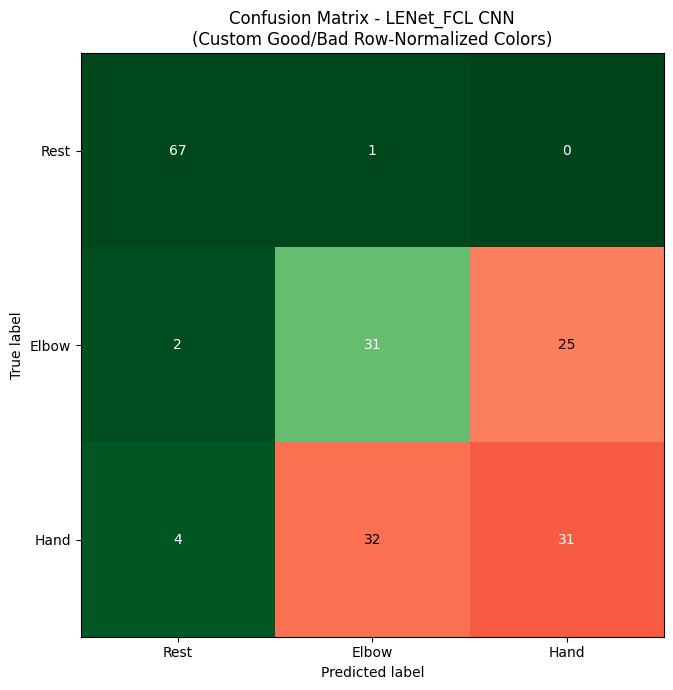


Figure 3: Confusion Matrix for LENet_FCL CNN.
This matrix visualizes classification performance with custom colors based on row-normalized values
Overall Accuracy: 66.84%.
Accuracy for Rest: 98.53%.
Accuracy for Elbow: 53.45%.
Accuracy for Hand: 46.27%.
----------------------------------------------------------------------


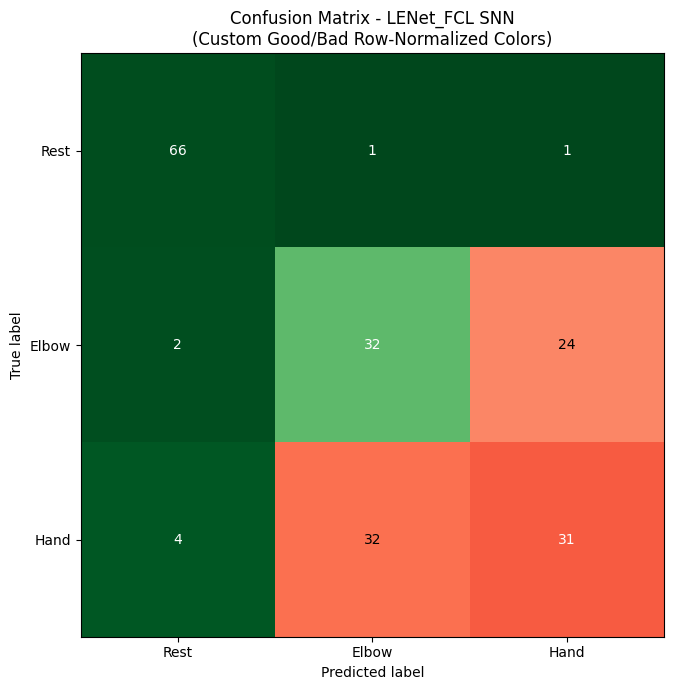


Figure 4: Confusion Matrix for LENet_FCL SNN.
This matrix visualizes classification performance with custom colors based on row-normalized values
Overall Accuracy: 66.84%.
Accuracy for Rest: 97.06%.
Accuracy for Elbow: 55.17%.
Accuracy for Hand: 46.27%.
----------------------------------------------------------------------


--- Model Performance Summary Table ---
| Model             | Overall Acc.    | Rest Acc.    | Elbow Acc.   | Hand Acc.    |
|-------------------|-----------------|--------------|--------------|--------------|
| LENet CNN         | 72.54%          | 97.06%       | 60.34%       | 58.21%       |
| LENet SNN         | 73.58%          | 97.06%       | 65.52%       | 56.72%       |
| LENet_FCL CNN     | 66.84%          | 98.53%       | 53.45%       | 46.27%       |
| LENet_FCL SNN     | 66.84%          | 97.06%       | 55.17%       | 46.27%       |


In [12]:
# @title visualize results (Custom confusion matrix, green good, red bad)
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib # For colormaps access

# Ensure all necessary variables from previous cells are available:
# cnn_model_lenet, snn_model_lenet, cnn_model_lenet_fcl, snn_model_lenet_fcl
# test_data, test_label (from the last train_test_split)
# EPOCHS, DROP_OUT, TEST_SIZE, BATCH_SIZE, TIME_STEPS, device (from training blocks)
# channel_count, num_classes, data_length (from data loading cell)
# all_data, all_label (from data loading cell, for full dataset stats)
# all_model_predictions, accuracy_results, true_labels_np (from previous evaluation steps)
# data_loader function (defined in a previous cell)

# --- 0. Report Header: Hyperparameters and Data Specifications (Table Format) ---
print("--- Experiment Configuration & Data Specifications ---")

# Collect all parameters
config_params = {
    "Dataset File": "sub-011_eeg.mat",
    "EEG Channels": channel_count if 'channel_count' in locals() else "N/A",
    "Data Shape (Full Dataset)": (
        f"Samples: {all_data.shape[0]}, Channels: {all_data.shape[1]}, Length: {all_data.shape[2]}"
        if 'all_data' in locals() and hasattr(all_data, 'shape') and len(all_data.shape) == 3
        else "N/A"),
    "Class Distribution (Full Dataset)": (
        f"Rest: {np.sum(all_label == 0)}, "
        f"Elbow: {np.sum(all_label == 1)}, "
        f"Hand: {np.sum(all_label == 2)}"
    ) if 'all_label' in locals() and isinstance(all_label, np.ndarray) and all_label.ndim >=1 else "N/A",
    "Bandpass Filter (Reported)": "7-35Hz", #Change in case other filtering technique was used
    "Sampling Ratio (Reported)": "90Hz", #Change in case other sampling was used
    "TRAINING EPOCHS": EPOCHS if 'EPOCHS' in locals() else "N/A",
    "Dropout": DROP_OUT if 'DROP_OUT' in locals() else "N/A",
    "Test Split": TEST_SIZE if 'TEST_SIZE' in locals() else "N/A",
    "Batch Size (Evaluation)": BATCH_SIZE if 'BATCH_SIZE' in locals() else "N/A",
    "SNN Time Steps": TIME_STEPS if 'TIME_STEPS' in locals() else "N/A"
}

# Determine column widths
max_key_len = max(len(key) for key in config_params.keys())
# Ensure values are strings for len() calculation
str_config_values = [str(val) for val in config_params.values()]
max_val_len = max(len(val) for val in str_config_values)

key_col_width = max_key_len + 2 # Add some padding
val_col_width = max_val_len + 2

# Print table header
print("+" + "-" * (key_col_width) + "+" + "-" * (val_col_width) + "+")
print(f"| {'Parameter':<{key_col_width-1}} | {'Value':<{val_col_width-1}} |")
print("+" + "=" * (key_col_width) + "+" + "=" * (val_col_width) + "+")

# Print table rows
for idx, (key, value) in enumerate(config_params.items()):
    print(f"| {key:<{key_col_width-1}} | {str(value):<{val_col_width-1}} |")

print("+" + "-" * (key_col_width) + "+" + "-" * (val_col_width) + "+")
print("\n") # Add a bit of space before the main output

# --- 1. Plot Confusion Matrices and Print Descriptions ---
# This section assumes all_model_predictions, true_labels_np, accuracy_results are pre-computed
# from previous cells if this cell is run in isolation.
print("\n--- Confusion Matrices and Descriptions ---")
class_names_display = ['Rest', 'Elbow', 'Hand'] # For display purposes in CM
figure_counter = 1

try:
    cmap_greens = matplotlib.colormaps['Greens']
    cmap_reds = matplotlib.colormaps['Reds']
except AttributeError: # Older matplotlib
    cmap_greens = plt.cm.get_cmap('Greens')
    cmap_reds = plt.cm.get_cmap('Reds')

# Thresholds for color logic
threshold_diagonal_good = 0.5  # Above this is green on diagonal
threshold_off_diagonal_bad = 0.2 # Above this is red on off-diagonal (significant misclassification)

# Check if necessary variables for plotting exist
if 'all_model_predictions' in locals() and 'true_labels_np' in locals() and 'accuracy_results' in locals():
    for model_name, predictions in all_model_predictions.items():
        cm = confusion_matrix(true_labels_np, predictions, labels=range(len(class_names_display)))

        # --- Custom Color Logic V2 ---
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_normalized_row = np.zeros_like(cm, dtype=float)
        for r_idx in range(cm.shape[0]):
            if row_sums[r_idx, 0] > 0:
                cm_normalized_row[r_idx, :] = cm[r_idx, :] / row_sums[r_idx, 0]

        num_classes_cm = cm.shape[0]
        color_matrix_rgb = np.zeros((num_classes_cm, num_classes_cm, 3))
        colormap_input_values = np.zeros((num_classes_cm, num_classes_cm))


        for i in range(num_classes_cm):
            for j in range(num_classes_cm):
                norm_value = cm_normalized_row[i, j]
                color_val_for_cmap = 0.0

                if row_sums[i, 0] == 0:
                    color_matrix_rgb[i, j, :] = [0.95, 0.95, 0.95]
                elif i == j:
                    if norm_value > threshold_diagonal_good:
                        color_val_for_cmap = norm_value
                        color_matrix_rgb[i, j, :] = cmap_greens(color_val_for_cmap)[:3]
                    else:
                        color_val_for_cmap = 1.0 - norm_value
                        color_matrix_rgb[i, j, :] = cmap_reds(color_val_for_cmap)[:3]
                else:
                    if norm_value > threshold_off_diagonal_bad:
                        color_val_for_cmap = norm_value
                        color_matrix_rgb[i, j, :] = cmap_reds(color_val_for_cmap)[:3]
                    else:
                        color_val_for_cmap = 1.0 - norm_value
                        color_matrix_rgb[i, j, :] = cmap_greens(color_val_for_cmap)[:3]
                colormap_input_values[i,j] = color_val_for_cmap
        # --- End Custom Color Logic V2 ---

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_display)
        fig, ax = plt.subplots(figsize=(8, 7))
        disp.plot(ax=ax, include_values=True, cmap='Greys', colorbar=False, values_format='d')

        if ax.images:
            ax.images[0].remove()
        ax.imshow(color_matrix_rgb)

        if disp.text_ is not None:
            for i in range(num_classes_cm):
                for j in range(num_classes_cm):
                    if disp.text_[i, j] is not None:
                        text_color = "white" if colormap_input_values[i,j] > 0.5 else "black"
                        if row_sums[i,0] == 0:
                            text_color = "black"
                        disp.text_[i, j].set_color(text_color)

        ax.set_title(f'Confusion Matrix - {model_name}\n(Custom Good/Bad Row-Normalized Colors)')
        plt.tight_layout()
        plt.show()

        print(f"\nFigure {figure_counter}: Confusion Matrix for {model_name}.")
        print(f"This matrix visualizes classification performance with custom colors based on row-normalized values")


        # Ensure class_names is defined for accessing accuracy_results
        class_names_for_acc = ['Rest', 'Elbow', 'Hand'] # Define or ensure it's passed from global scope

        overall_acc_val = accuracy_results[model_name]['Overall'] * 100
        print(f"Overall Accuracy: {overall_acc_val:.2f}%.")
        for class_idx, class_name_label in enumerate(class_names_display):
            # Use a consistent key for accuracy_results, assuming class_names_for_acc matches keys
            current_class_key = class_names_for_acc[class_idx]
            if current_class_key in accuracy_results[model_name]:
                class_acc_val = accuracy_results[model_name][current_class_key]
                if not np.isnan(class_acc_val):
                    print(f"Accuracy for {class_name_label}: {class_acc_val*100:.2f}%.")
                else:
                    print(f"Accuracy for {class_name_label}: N/A (value is NaN).")
            else:
                print(f"Accuracy for {class_name_label}: N/A (key not found).")
        print("-" * 70)
        figure_counter += 1
else:
    print("Required variables (all_model_predictions, true_labels_np, or accuracy_results) not found for plotting confusion matrices.")


# --- 2. Accuracy Table ---
print("\n\n--- Model Performance Summary Table ---")
# Ensure class_names is defined for table header
class_names_for_table = ['Rest', 'Elbow', 'Hand'] # Define or ensure it's passed

if 'accuracy_results' in locals():
    header = f"| {'Model':<17} | {'Overall Acc.':<15} | {class_names_for_table[0]+' Acc.':<12} | {class_names_for_table[1]+' Acc.':<12} | {class_names_for_table[2]+' Acc.':<12} |"
    separator = "|-------------------|-----------------|--------------|--------------|--------------|"
    print(header)
    print(separator)
    for model_name_key in accuracy_results:
        overall_str = f"{accuracy_results[model_name_key]['Overall']*100:.2f}%"

        rest_acc_val = accuracy_results[model_name_key].get(class_names_for_table[0], np.nan)
        rest_str = f"{rest_acc_val*100:.2f}%" if not np.isnan(rest_acc_val) else "N/A"

        elbow_acc_val = accuracy_results[model_name_key].get(class_names_for_table[1], np.nan)
        elbow_str = f"{elbow_acc_val*100:.2f}%" if not np.isnan(elbow_acc_val) else "N/A"

        hand_acc_val = accuracy_results[model_name_key].get(class_names_for_table[2], np.nan)
        hand_str = f"{hand_acc_val*100:.2f}%" if not np.isnan(hand_acc_val) else "N/A"

        row = f"| {model_name_key:<17} | {overall_str:<15} | {rest_str:<12} | {elbow_str:<12} | {hand_str:<12} |"
        print(row)
else:
    print("Accuracy results not available for summary table.")


In [30]:
# @title Energy consumption estimation and comparison
import torch
import torch.nn as nn
# Note: Ensure that the LENet, LENet_FCL classes, and initialize_weights function
# are defined in a previous cell. Also, 'device', 'channel_count',
# and 'data_length' should be available from your data loading and setup cells.
# If cnn_model_lenet and cnn_model_lenet_fcl (trained models) exist,
# they will be used; otherwise, new instances are created for architecture analysis.

# --- Energy Calculation Constants (original in pJ) ---
E_MAC_PJ = 4.6  # pJ per MAC operation
E_AC_PJ = 0.9   # pJ per AC operation (for SNN spike processing)

# Conversion factor from pJ to µJ
PJ_TO_UJ = 1e-6

def get_macs_and_energy_final(
    model, sample_input, model_name="Model", T_snn_param=100, avg_firing_rate=0.02, conversion_factor=1.0
):
    """
    Calculates MACs and estimates energy consumption for ANN and SNN versions.
    Returns energy in units determined by conversion_factor.
    Formats energy values as floats with two decimal places.
    Formats Total MACs as integers with commas.
    """
    layer_flops_mac_list = []
    hooks = []

    def hook_fn_flops(module, input_tensor_tuple, output_tensor):
        macs = 0
        if isinstance(module, nn.Conv2d):
            c_in = module.in_channels
            c_out = module.out_channels
            k_h, k_w = module.kernel_size
            h_out, w_out = output_tensor.shape[2], output_tensor.shape[3]
            groups = module.groups
            macs = (c_in // groups) * k_h * k_w * c_out * h_out * w_out
        elif isinstance(module, nn.Linear):
            n_in = module.in_features
            n_out = module.out_features
            macs = n_in * n_out
        if macs > 0:
            layer_flops_mac_list.append(macs)

    for _, module_item in model.named_modules():
        if isinstance(module_item, (nn.Conv2d, nn.Linear)):
            hooks.append(module_item.register_forward_hook(hook_fn_flops))

    model.eval()
    model_device = next(model.parameters()).device
    with torch.no_grad():
        model(sample_input.to(model_device))

    for h in hooks:
        h.remove()

    total_macs_all_layers = sum(layer_flops_mac_list) # Integer
    energy_ann_pj = E_MAC_PJ * float(total_macs_all_layers) # Use float for energy calc

    if not layer_flops_mac_list:
        energy_snn_pj = 0.0
    else:
        macs_layer1_for_snn = float(layer_flops_mac_list[0])
        energy_snn_term1_pj = E_MAC_PJ * macs_layer1_for_snn
        sops_sum_layers_2_L = 0.0
        for i in range(1, len(layer_flops_mac_list)):
            macs_layer_i = float(layer_flops_mac_list[i])
            sops_layer_i = avg_firing_rate * T_snn_param * macs_layer_i
            sops_sum_layers_2_L += sops_layer_i
        energy_snn_term2_pj = E_AC_PJ * sops_sum_layers_2_L
        energy_snn_pj = energy_snn_term1_pj + energy_snn_term2_pj

    energy_ann_converted = energy_ann_pj * conversion_factor
    energy_snn_converted = energy_snn_pj * conversion_factor

    output_unit_str = "µJ" if conversion_factor == PJ_TO_UJ else "pJ"

    return {
        "Model": model_name,
        "Total MACs": f"{total_macs_all_layers:,}", # Integer with commas
        f"ANN Energy ({output_unit_str})": f"{energy_ann_converted:,.2f}",
        f"SNN Energy ({output_unit_str})": f"{energy_snn_converted:,.2f}",
    }

# --- Prepare models and input for energy calculation ---
if 'device' not in locals():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # print(f"Warning: 'device' not found, defaulting to {device}") # Silenced for cleaner output
if 'channel_count' not in locals():
    channel_count = 60
    # print(f"Warning: 'channel_count' not found, defaulting to {channel_count}")
if 'data_length' not in locals():
    data_length = 1000
    # print(f"Warning: 'data_length' not found, defaulting to {data_length}")
if 'TIME_STEPS' not in locals():
    TIME_STEPS = 100
    # print(f"Warning: 'TIME_STEPS' not found, defaulting to {TIME_STEPS}")
if 'DROP_OUT' not in locals():
    DROP_OUT = 0.25
    # print(f"Warning: 'DROP_OUT' not found, defaulting to {DROP_OUT}")

sample_input_tensor = torch.randn(1, 1, channel_count, data_length)

# Model 1: LENet (CCB)
if 'cnn_model_lenet' in locals() and isinstance(cnn_model_lenet, nn.Module):
    # print("Using existing 'cnn_model_lenet' for LENet (CCB) energy calculation.") # Silenced
    model_for_energy_lenet_ccb = cnn_model_lenet
else:
    print("Warning: 'cnn_model_lenet' not found. Initializing new LENet for energy calculation.")
    try:
        model_for_energy_lenet_ccb = LENet(classes_num=3, channel_count=channel_count, drop_out=DROP_OUT).to(device)
        if 'initialize_weights' in locals(): model_for_energy_lenet_ccb.apply(initialize_weights)
    except NameError:
        print("Error: LENet class definition not found.")
        model_for_energy_lenet_ccb = None

# Model 2: LENet_FCL
if 'cnn_model_lenet_fcl' in locals() and isinstance(cnn_model_lenet_fcl, nn.Module):
    # print("Using existing 'cnn_model_lenet_fcl' for LENet_FCL energy calculation.") # Silenced
    model_for_energy_lenet_fcl = cnn_model_lenet_fcl
    model_for_energy_lenet_fcl.eval()
    with torch.no_grad():
        model_for_energy_lenet_fcl(sample_input_tensor.to(device))
else:
    print("Warning: 'cnn_model_lenet_fcl' not found. Initializing new LENet_FCL for energy calculation.")
    try:
        model_for_energy_lenet_fcl = LENet_FCL(classes_num=3, channel_count=channel_count, drop_out=DROP_OUT).to(device)
        if 'initialize_weights' in locals(): model_for_energy_lenet_fcl.apply(initialize_weights)
        model_for_energy_lenet_fcl.eval()
        with torch.no_grad():
            model_for_energy_lenet_fcl(sample_input_tensor.to(device))
    except NameError:
        print("Error: LENet_FCL class definition not found.")
        model_for_energy_lenet_fcl = None

# --- Perform Energy Calculations ---
AVG_FIRING_RATE = 0.02 # 2%
energy_results_list_final = []

CURRENT_CONVERSION_FACTOR = PJ_TO_UJ
OUTPUT_UNIT_NAME = "µJ"

if model_for_energy_lenet_ccb:
    results_lenet_final = get_macs_and_energy_final(
        model_for_energy_lenet_ccb,
        sample_input_tensor,
        model_name="LENet (CCB)",
        T_snn_param=TIME_STEPS,
        avg_firing_rate=AVG_FIRING_RATE,
        conversion_factor=CURRENT_CONVERSION_FACTOR
    )
    energy_results_list_final.append(results_lenet_final)
# else: # Silenced for cleaner output
    # print("Skipping LENet (CCB) energy calculation as model was not available.")

if model_for_energy_lenet_fcl:
    results_lenet_fcl_final = get_macs_and_energy_final(
        model_for_energy_lenet_fcl,
        sample_input_tensor,
        model_name="LENet FCL",
        T_snn_param=TIME_STEPS,
        avg_firing_rate=AVG_FIRING_RATE,
        conversion_factor=CURRENT_CONVERSION_FACTOR
    )
    energy_results_list_final.append(results_lenet_fcl_final)
# else: # Silenced for cleaner output
    # print("Skipping LENet FCL energy calculation as model was not available.")

# --- Generate Markdown Table ---
if energy_results_list_final:
    # Table title is now part of the initial print statements from your notebook
    # markdown_table_final = f"Table 2. Estimated Theoretical Energy Consumption per Inference.\n"
    markdown_table_final = "" # Start with an empty string for the table itself

    # Adjusted column widths and alignment to match the image
    # | Model         | Total MACs   | ANN Energy (µJ) | SNN Energy (µJ) |
    # |:--------------|:-------------|:----------------|:----------------|
    # Widths: Model: 13, Total MACs: 12, ANN Energy: 15, SNN Energy: 15 (approx from image)

    markdown_table_final += f"| Model       | Total MACs   | ANN Energy ({OUTPUT_UNIT_NAME}) | SNN Energy ({OUTPUT_UNIT_NAME}) |\n"
    markdown_table_final += f"|:------------|:-------------|:----------------|:----------------|\n"

    for result in energy_results_list_final:
        markdown_table_final += (
            f"| {result['Model']:<11} | "  # Adjusted width
            f"{result['Total MACs']:>12} | "
            f"{result[f'ANN Energy ({OUTPUT_UNIT_NAME})']:>15} | "
            f"{result[f'SNN Energy ({OUTPUT_UNIT_NAME})']:>15} |\n"
        )

    # The newline after the table is handled by the print statement for constants
    # markdown_table_final += "\n"

    constants_line = (
        f"Constants used: E_MAC = ({E_MAC_PJ:.1f} pJ), "
        f"E_AC = ({E_AC_PJ:.1f} pJ). "
        f"SNN parameters: T = {TIME_STEPS}, "
        f"Assumed Average Firing Rate (fr) = {AVG_FIRING_RATE*100:.0f}%."
    )
    # Print the table first, then the constants on a new line
    print(markdown_table_final)
    print(constants_line)
else:
    print("No energy consumption results to display. Please check model availability and definitions.")



| Model       | Total MACs   | ANN Energy (µJ) | SNN Energy (µJ) |
|:------------|:-------------|:----------------|:----------------|
| LENet (CCB) |   33,973,008 |          156.28 |           93.15 |
| LENet FCL   |   33,973,008 |          156.28 |           93.15 |

Constants used: E_MAC = (4.6 pJ), E_AC = (0.9 pJ). SNN parameters: T = 100, Assumed Average Firing Rate (fr) = 2%.
